# Mapa de Emociones

El objetivo de este proyecto es el de usar redes neuronales de tipo BERT y SOM para realizar análisis de sentimientos. Se tiene interés en el espacio topologico donde la red BERT genera embeddings, y se quiere visualizar usando la red SOM.


Se tiene una red neuronal de tipo BERT, la cual realizó fine-tuning en la tarea de clasificación de sentimientos. Aunque esta red puede tomar oraciones y asignarles su sentimiento, se tiene interés en el embedding de oraciones que puede realizar la red. Recordar que, cuando se tiene una red tipo BERT, y esta toma una oración como input, el vector asociado al token CLS puede ser usado como embedding de la oración. Por lo tanto, las redes neuronales BERT se pueden considerar como formas de vectorización de oraciones. Dado que nuestra red BERT fue entrenada en clasificación de sentimientos, esta tiene especial conocimiento en esta área. Por lo tanto, puede ser usada para realizar vectorizaciones de oraciones donde el sentimiento de la oración es crucial para hacer el embedding. 


Se quiere visualizar el espacio de embeddings del BERT. Para esto, se usa una red tipo SOM. Estas redes neuronales pueden ser usadas para visualizar espacios topológicos de dimensiones altas. Se va a entrenar una SOM en el espacio de embeddings del BERT para visualizar como se distribuyen las emociones en este. Por lo tanto, lo que se busca obtener es un mapa de emociones, el cual es la representación realizada por el SOM del espacio de embeddings del BERT.


Para realizar esto, se usa un conjunto de oraciones con sentimientos. Estas se vectorizan usando el BERT, y despues se obtiene el mapa de emociones de estos vectores usando el SOM. 


Obtener el mapa de emociones es de utilidad para observar como el BERT separa las emociones entre si (es lo que se espera). Es decir, se puede usar para obtener información sobre la forma de realizar embeddings del BERT. Ademas, como se ejemplifica al final del proyecto, el mapa de emociones puede ser usando para asignar emociones a oraciones no presentes en el conjunto de datos.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from matplotlib import animation, colors

Se asume que ya se tiene acceso al conjunto de datos. Este se encuentra en un archivo .csv llamado "oraciones.csv"

In [2]:
# cargar y ver los datos
df = pd.read_csv("oraciones.csv")

# ver
df.head()

,Unnamed: 0,Text,Emotion
0,7797,i feel heartbroken but for some reason not str...,sadness
1,14663,i have one toe that is starting to feel kind o...,sadness
2,5865,i feel honoured to become a journalist on his ...,happy
3,11828,when my grandmother came to stay with us perma...,anger
4,4511,i cant shake the im hiding how i feel about my...,happy


In [3]:
# ver la forma
print(f"Forma de los datos: {df.shape}")

Forma de los datos: (21459, 3)


Se tienen 21,459 oraciones, cada una con su respectiva emocion.

Se tienen oraciones, con sus respectivas etiquetas. Se separa esa información en vectores separados

In [4]:
oraciones = list(df['Text'].values)
emociones = df['Emotion'].values

## Transformers: Vectorizar las oraciones.

Usar un BERT para obtener los embeddings de las oraciones.

Se usa un BERT que realizó fine-tuning en la tarea de clasificación de sentimientos. Es decir, esta red neuronal sabe como diferenciar las emociones que pueden estar presentes en una oracion.

No nos importa la clasificación que este modelo pueda brindar. Lo que es de interés es el vector asociado al token CLS del modelo. Para cada oración, esta red neuronal otortga varios vectores; especificamente, el vector asociado al token CLS se usa como un embedding de la oración.

Por lo tanto, para cada oración del conjunto de datos, se va a meter al BERT, se va a tomar el vector del token CLS, y se va a usar este vector como la representación vectorial del vector. Debido al entrenamiento del modelo, esta representación vectorial va a ser de acuerdo a la emoción de la oración.

Esto permite apreciar la capacidad de los modelos BERT para las tareas relacionadas con lenguaje.

In [5]:
import transformers
from transformers import BertForSequenceClassification, AutoTokenizer
import torch

El modelo BERT entrenado se obtiene de la librería Hugging Face, librería usada para varias tareas relacionadas con deep learning.

Se usa el modelo encontrado en el siguiente link: https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion?text=i+think+i+dont+remember+this

In [6]:
# especificar el nombre del modelo
name_modelo = "bhadresh-savani/bert-base-uncased-emotion"

# descargar el modelo y el tokenizador
tokenizer = AutoTokenizer.from_pretrained(name_modelo)
model = BertForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")

Hacer una función que use el modelo BERT descargado para obtener representaciones vectoriales de una lista de oraciones.

In [7]:
def vectorizar_oraciones(lista_oraciones):
    # toma una lista de oraciones
    # las vectoriza usando el modelo

    # placeholder
    vectores = np.array([]).reshape(0, 768)

    print("Vectorizando")

    # el proceso se debe de hacer por baches
    # pues mi computadora se queda sin memoria
    n = 5
    # iterar en los "batches"
    for i in range(0, len(lista_oraciones), n):

        batch = lista_oraciones[i:i+n]

        # obtener el resultado del batch
        # pasar las strings por el tokenizador
        inputs = tokenizer(batch,  padding=True, truncation=True, return_tensors="pt")

        # obtener los outputs del modelo
        with torch.no_grad():
            outputs = model.bert(**inputs)

        # concatenarlo con los resultados totales
        vectores = np.vstack((vectores, outputs.pooler_output))

        print(f'Progreso: [{min(i+n, len(lista_oraciones))}/{len(lista_oraciones)}]')

    return vectores

Ver un ejemplo de como obtener vectores a partir de oraciones.

In [8]:
oraciones_ejemplo = ["This is an example" , "we have two sentences"]
print(f"Numero de oraciones: {len(oraciones_ejemplo)}")

vectores_ejemplo = vectorizar_oraciones(oraciones_ejemplo)
print(f"Forma de los vectores: {vectores_ejemplo.shape}")

Numero de oraciones: 2
Vectorizando
Progreso: [2/2]
Forma de los vectores: (2, 768)


Vectorizar todas las oraciones del conjunto de datos.

Debido a la complejidad de la red neuronal tipo BERT, este proceso toma mucho tiempo computacional. Por lo tanto, despues de vectorizar las oraciones, estos vectores se salvan. Antes de hacer la vectorización se intentan cargar los vectores, en caso de que hayan sido calculados y salvados previamente.

In [9]:
# nombre de como se guardan los vectores
name_vectores = "vectores.npy"

# intentar cargar los vectores
try:

  X = np.load(name_vectores)

  # indicar que se cargaron
  print("Las vectorizaciones fueron realizadas previamente")
  print("Estas se cargan")

# si no se pueden cargar los vectores
# se crean y se salvan
except:

  print("No se pueden cargar los vectores")
  print("Estos se crean y se salvan")

  # vectorizar
  X = vectorizar_oraciones(oraciones)

  # salvar
  np.save(name_vectores, X)

Las vectorizaciones fueron realizadas previamente
Estas se cargan


In [10]:
# ver la forma
print(f"Forma de los vectores: {X.shape}")

Forma de los vectores: (21459, 768)


Por cada oracion se tiene un vector de 768 entradas.

## Self Organizing Map: Obtener el mapa de las emociones.

Se usa una Self-Organizing-Map (SOM) para poder visualizar los vectores obtenidos con el modelo BERT. Recordar que el BERT nos da un vector por oración, estos vectores tienen 768 entradas. Se va a usar una SOM para poder representar este espacio en dos dimensiones.

El objetivo es poder observar la distribución de las emociones en el espacio de dos dimensiones. La SOM no tiene acceso a las etiquetas de las oraciones, solo obtiene la representacion usando la cercania de los vectores, es decir, usando el espacio topológico creado por el BERT. Al tener las etiquetas de estas oraciones, podemos colorear el resultado de la SOM para analizar como se distribuyen las oraciones.

Para la implementación de la SOM, tomo inspiración en el siguiente link: https://towardsdatascience.com/understanding-self-organising-map-neural-network-with-python-code-7a77f501e985

Definir hiperparametros

In [11]:
# Hiperparametros
NUM_ROWS = 12
NUM_COLS = 12
MAX_NB_RANGE = 4
MAX_LR = 0.8
NUM_EPOCHS = 10

In [12]:
# calcular el numero de pasos totales
# segun el numero de epocas y el tamaño de los datos
max_steps = NUM_EPOCHS * df.shape[0]

print(f"En total se hacen {max_steps} pasos de entrenamiento")

En total se hacen 214590 pasos de entrenamiento


Normalizar los datos

In [13]:
# definir el escalador
scaler = MinMaxScaler()

# normalizarlos
X_norm = scaler.fit_transform(X)

Codificar las etiquetas de los datos usando numeros

In [14]:
# codificar las emociones con numeros
dict_emociones = {'anger':1, 'sadness':2, 'fear':3, 'surprise':4, 'love':5, 'happy':6 }

dict_emociones

{'anger': 1, 'sadness': 2, 'fear': 3, 'surprise': 4, 'love': 5, 'happy': 6}

In [15]:
# cambar las etiquetas de emociones a numeros
emociones_codificadas = [dict_emociones[e] for e in emociones]

In [16]:
# hacer un diccionario que tome los numeros y devuelva las emociones

# inicializar
dict_emociones_inv = {}

for emocion, numero in dict_emociones.items():
    dict_emociones_inv[numero] = emocion
    
dict_emociones_inv

{1: 'anger', 2: 'sadness', 3: 'fear', 4: 'surprise', 5: 'love', 6: 'happy'}

Funciones de distancias

In [17]:
# calcular distancia euclideana entre vectores
def euclidean_distance(x,y):
  return distance.euclidean(x,y)

# calcular distancia del coseno entre vectores
def cosine_distance(x,y):
  return distance.cosine(x,y)

# calcular distancia del manhattan entre vectores
def manhattan_distance(x,y):
  return distance.cityblock(x,y)

In [18]:
# obtener la neurona mas cercana a un input pattern
def bmu_neuron(input_data, som):
  # Argumentos:
  # input_data - input patter
  # som - la matriz de pesos de la som
  # num-rows - numero de filas en la som
  # num-cols - numero de columnas en la som

  # iterar en todas las neuronas
  # calcular la distancia a todas ellas
  # ver cual es la menor, ir actualizando
  # iniciar con bmu nula y distancia menor infinita
  bmu = [-1, -1]
  distancia_menor = np.inf

  # iterar en las neuronas
  for row in range(NUM_ROWS):
    for col in range(NUM_COLS):

      # tomar el vector de esa neurona en el input space
      neuron_vector = som[row][col]
      # calcular la distancia con el input pattern
      distancia = euclidean_distance(neuron_vector, input_data)

      # si es la menor hasta ahora, actualizar el ganador
      if distancia < distancia_menor:
        distancia_menor = distancia
        bmu = [row, col]

  # devolver las coordenadas de la neurona ganadora
  return bmu

In [19]:
# calcular el learning_rate y neighbourhood_range
# de cierta iteracion en el entrenamiento, usando decay
def lr_and_nb_range(step, max_steps):

  # calcular que porcentaje del entrenamiento que falta
  porcentaje_restante = 1 - (step/max_steps)

  # calcular el learning rate, este va decrementando
  learning_rate = porcentaje_restante * MAX_LR

  # calcular el rango del vecindario, este va decrementando
  neighbourhood_range = ceil(porcentaje_restante * MAX_NB_RANGE)

  # devolverlos
  return learning_rate, neighbourhood_range

Funcion para etiquetar la SOM

Poner etiquetas a las neuronas del SOM, de acuerdo a las etiquetas de los vectores cerca de ella en el input space.

In [20]:
def etiquetar_som(X, etiquetas, som):
  # toma unos datos con etiquetas, y una som
  # para cada neurona del som se pone una etiqueta
  # la etiqueta de una neurona es la que mas se repite
  # dentro de las etiquetas de los datos cuya
  # bmu es esa neurona

  # primero, para cada neurona, poner
  # una lista de las etiquetas de los datos
  # cuya bmu es esa neurona

  # 1) inicializar vacio
  map_lista = np.empty(shape=(NUM_ROWS, NUM_COLS), dtype=object)
  # poner una lista para cada neurona
  for row in range(NUM_ROWS):
    for col in range(NUM_COLS):
      # poner una lista vacia
      map_lista[row][col] = []

  # llenar las listas
  # iterar en los datos
  for t in range(X.shape[0]):

    # obtener la neurona mas cercana a ese dato
    bmu_winner = bmu_neuron(X[t], som)

    # en la coordenada de esa neurona, añadir la etiqueta de ese dato
    map_lista[bmu_winner[0]][bmu_winner[1]].append(etiquetas[t])

  # 2) tomar la lista de cada neurona, y seleccionar la moda

  # inicializar en ceros
  map_etiquetas = np.zeros(shape=(NUM_ROWS, NUM_COLS))

  # iterar en las neuronas
  for row in range(NUM_ROWS):
    for col in range(NUM_COLS):

      # tomar la lista asociada
      lista_neurona = map_lista[row][col]

      # si es vacia, poner etiqueta de -1
      if len(lista_neurona) == 0:
        label = -1

      # de otro modo, poner la moda
      else:
        label = max(lista_neurona, key = lista_neurona.count)

      # poner la etiqueta
      map_etiquetas[row][col] = label

  # devolverlo
  return map_etiquetas

Función para visualizar una SOM

In [21]:
# ver el diccionario de colores, segun las etiquetas
dict_colores = {}

# se agrega el de -1 (para neuronas vacias)
dict_colores[-1] = 'empty'

# poner el de 0 (que no se usa)
dict_colores[0] = '-'

# se completa con lo de las emociones
for num, emocion in dict_emociones_inv.items():
    dict_colores[num] = emocion

dict_colores

{-1: 'empty',
 0: '-',
 1: 'anger',
 2: 'sadness',
 3: 'fear',
 4: 'surprise',
 5: 'love',
 6: 'happy'}

In [22]:
def visualize(som, titulo = "Mapa SOM", save_name = None):
    # obtener las etiquetas
    etiquetas_som = etiquetar_som(X, emociones_codificadas, som)
    
    # haver la figura
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # quitar ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.imshow(etiquetas_som, vmin=min(list(dict_colores.keys())), vmax=max(list(dict_colores.keys())))
    plt.colorbar()
    
    # titulo
    ax.set_title(titulo)
    
    # poner los handles, para la leyenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=plt.cm.viridis((i+1)/(len(dict_colores)-1)))
               for i in dict_colores.keys()]
    # delimitar los labels de la leyenda                
    labels = [f'{i}: {dict_colores[i]}' for i in dict_colores.keys()]

    # Mostrar la leyenda
    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.4, 1))
    
    
    # ver si se salva
    if save_name is not None:
        plt.savefig(f'./imagenes/{save_name}.png')
        
    plt.show()

Inicializar la SOM

In [23]:
# inicializar la SOM
# esta tiene un vector en el input space por cada neurona
# se tienen num_rows x num_cols neuronas,
# cada una tiene un vector de 768 entradas
np.random.seed(40)
som = np.random.random_sample(size=(NUM_ROWS, NUM_COLS, X_norm.shape[1]))

print(f"Forma de la SOM: {som.shape}")

Forma de la SOM: (12, 12, 768)


Hacer el entrenamiento de la SOM

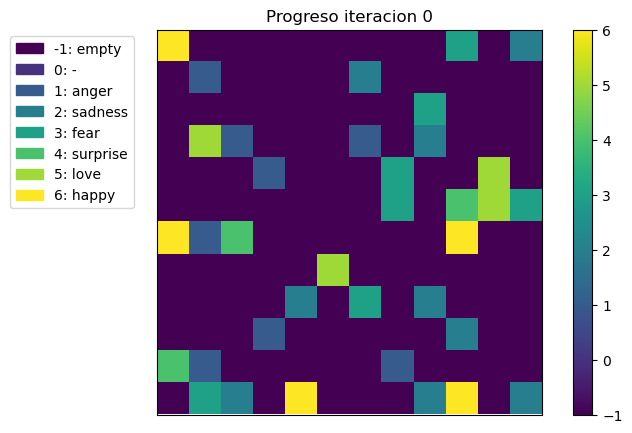

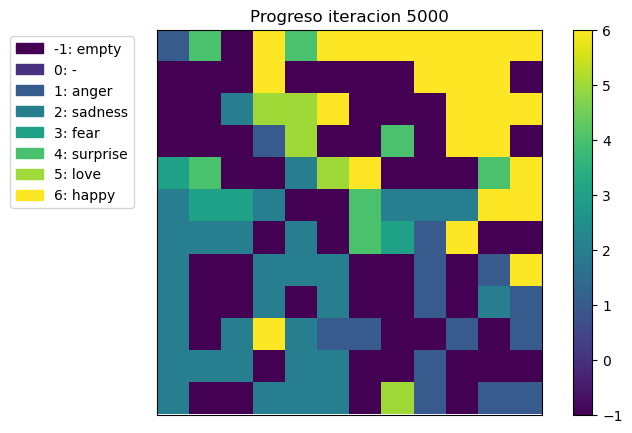

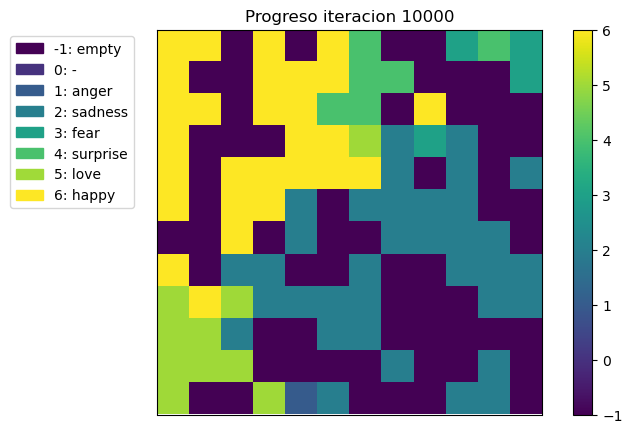

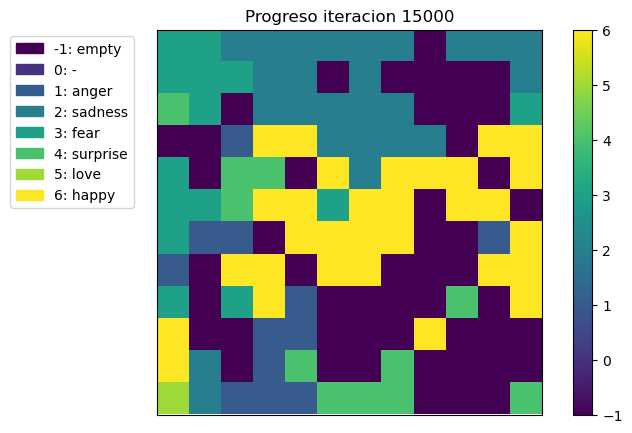

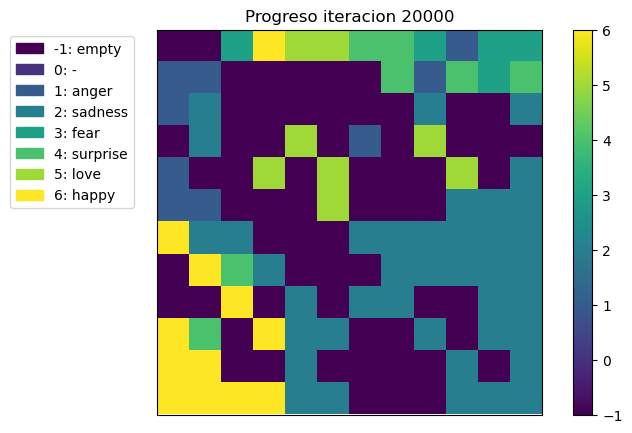

Epoch: [1/10]


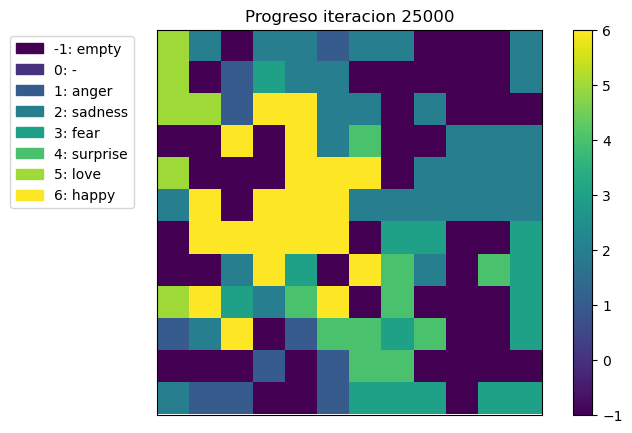

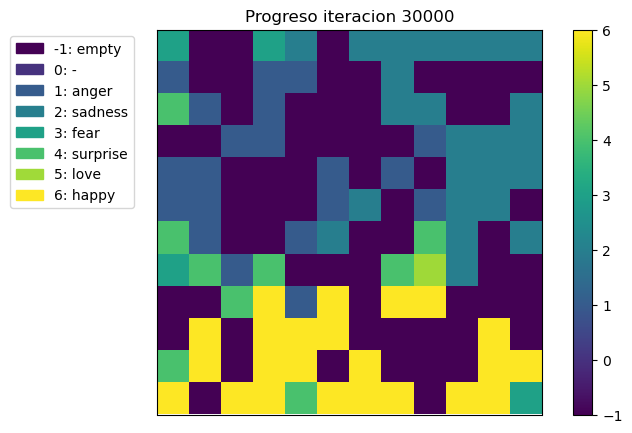

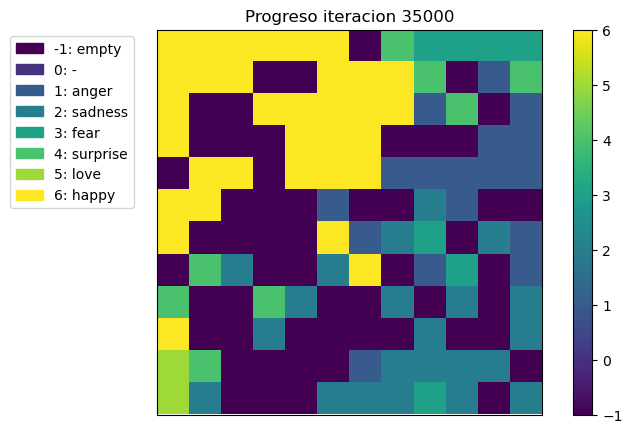

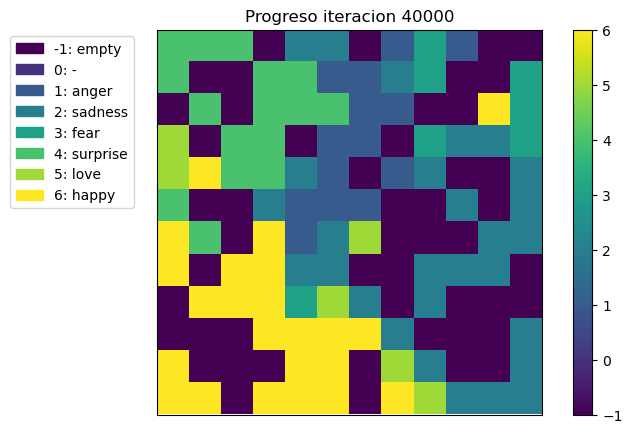

Epoch: [2/10]


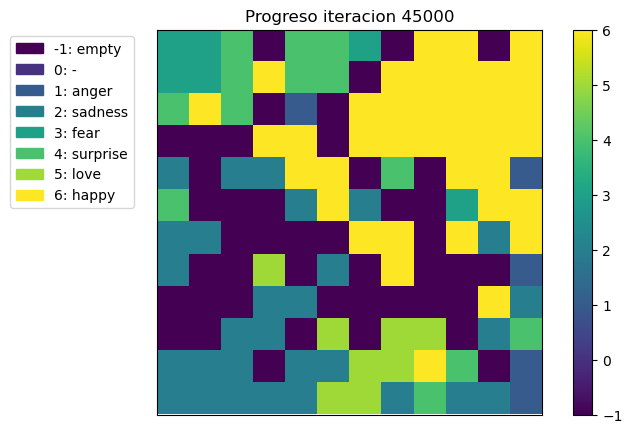

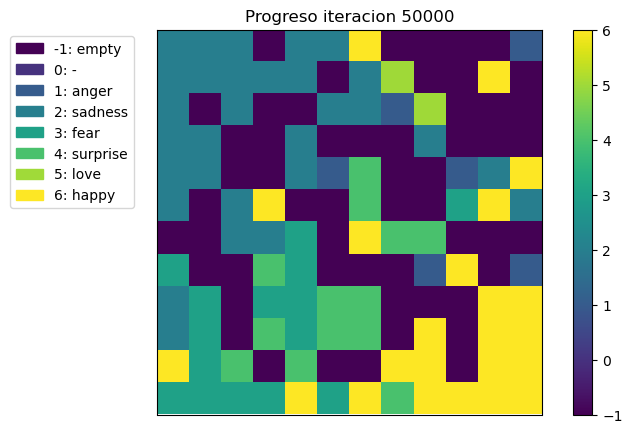

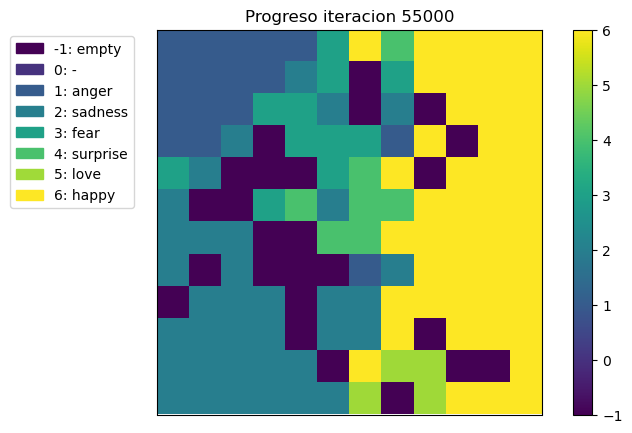

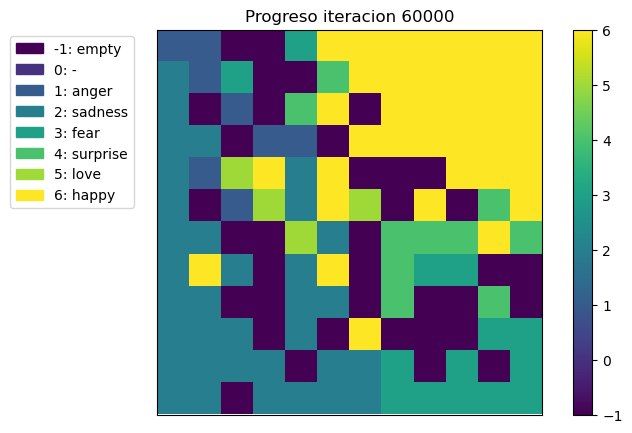

Epoch: [3/10]


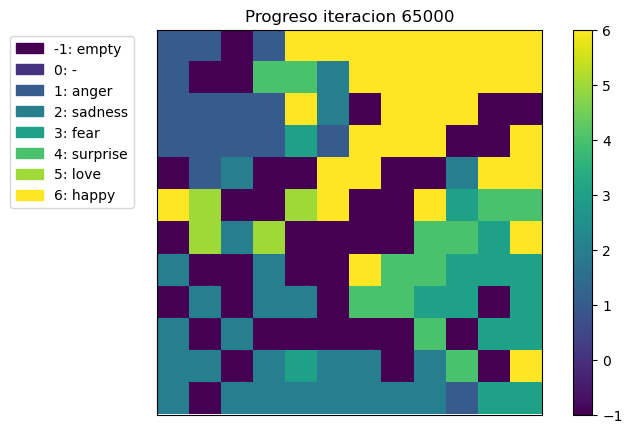

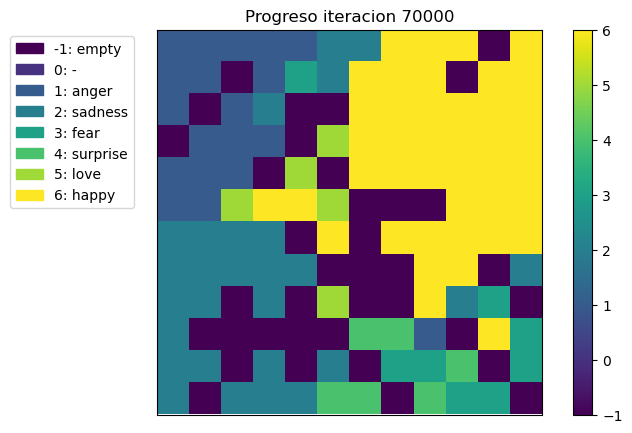

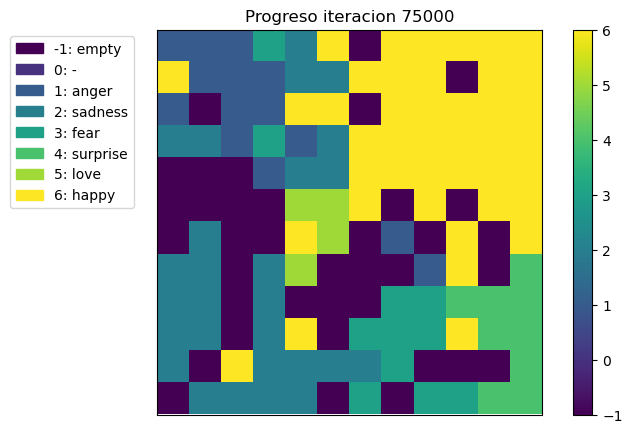

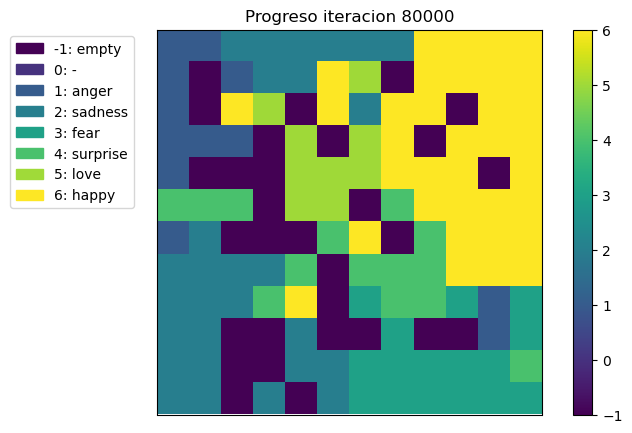

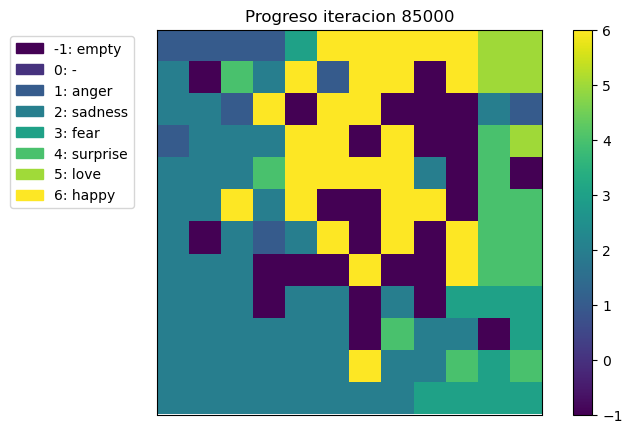

Epoch: [4/10]


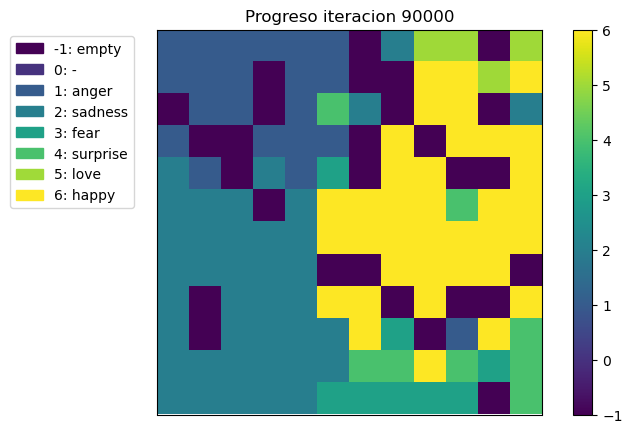

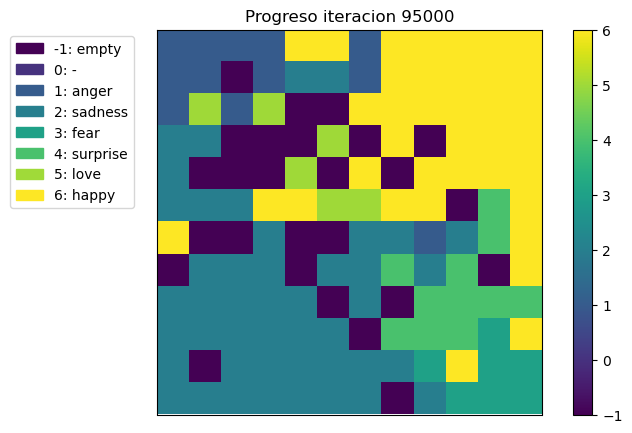

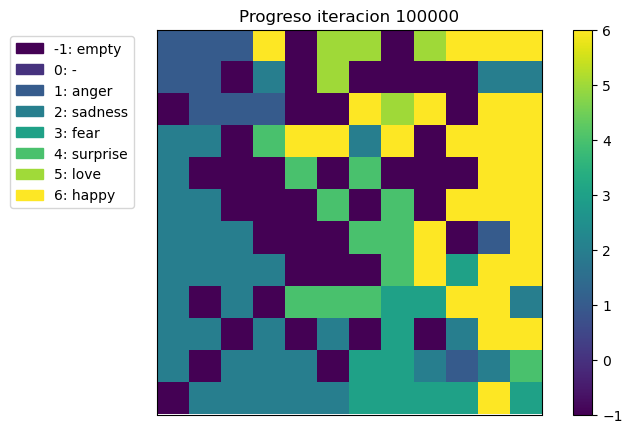

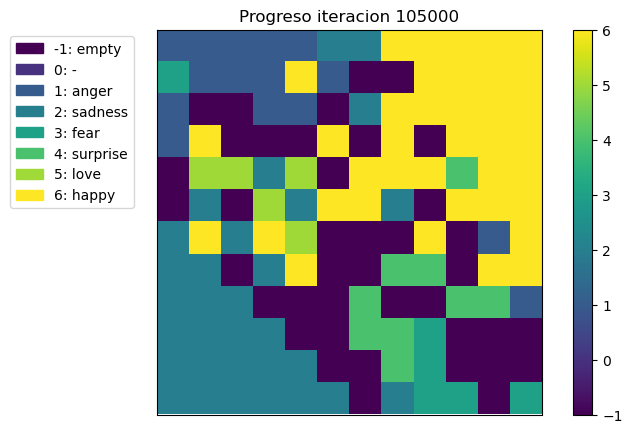

Epoch: [5/10]


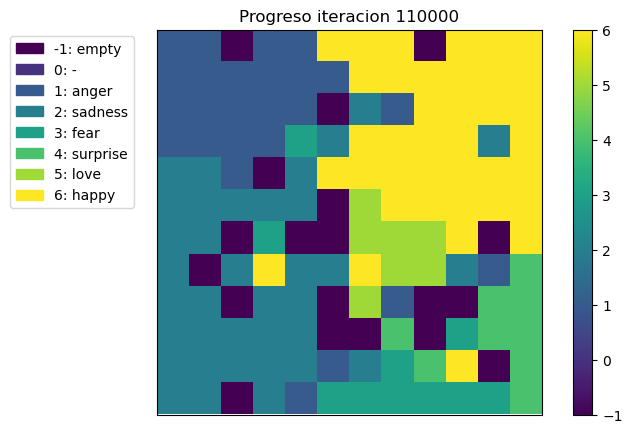

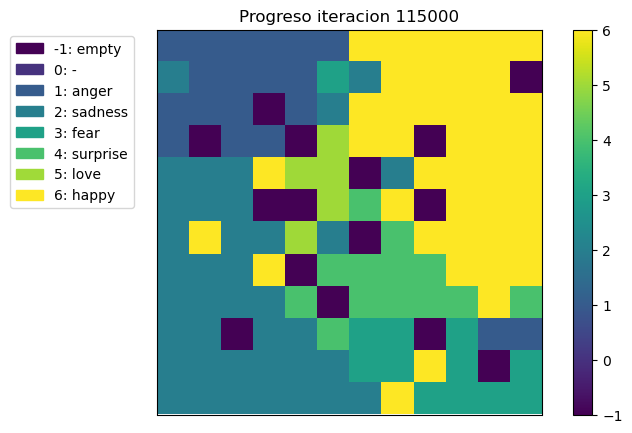

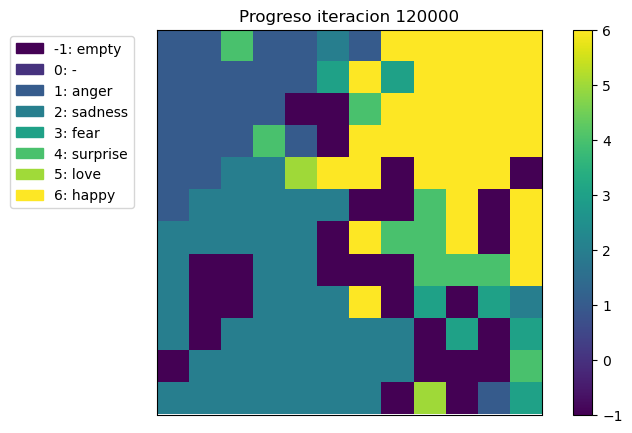

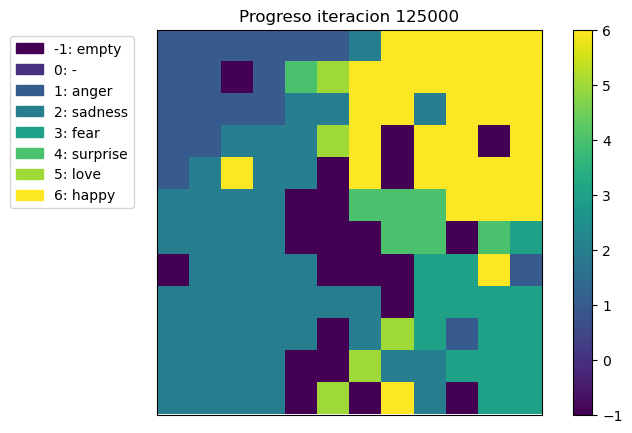

Epoch: [6/10]


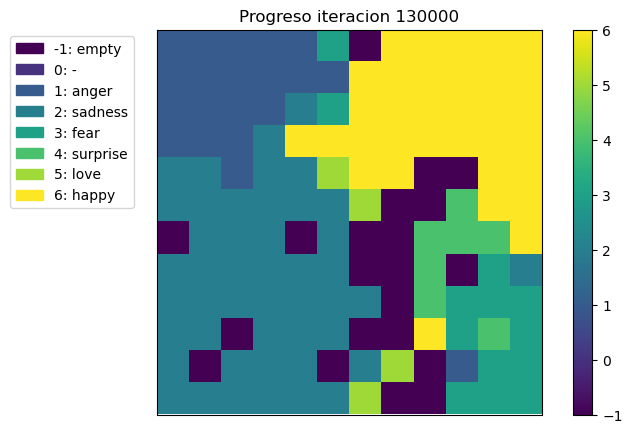

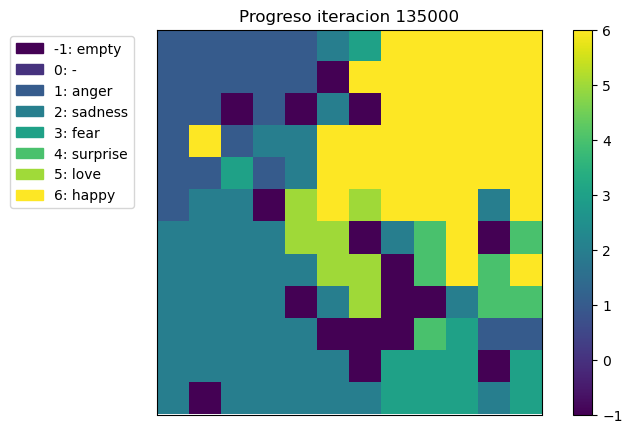

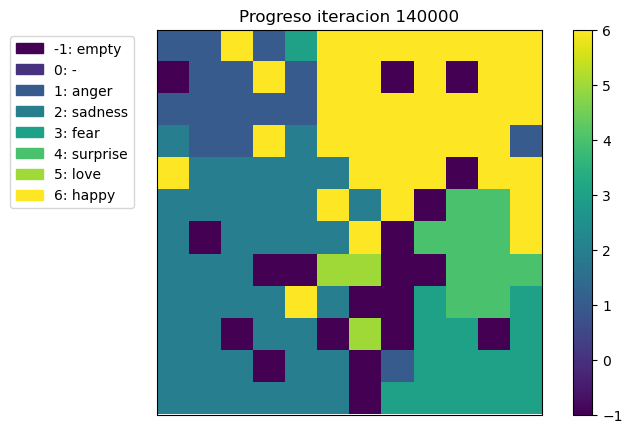

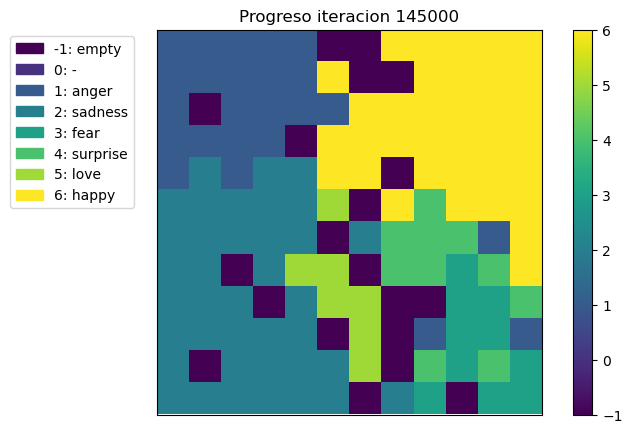

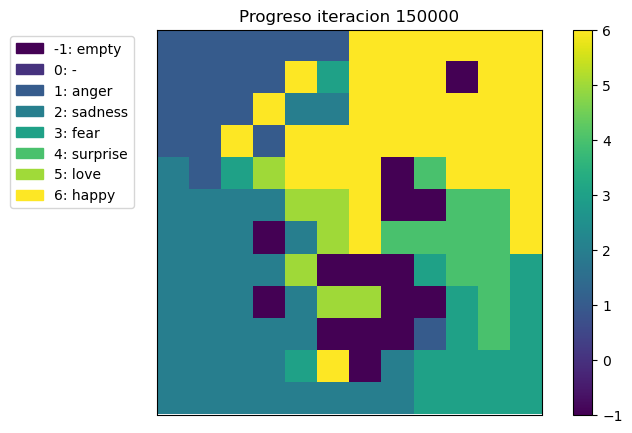

Epoch: [7/10]


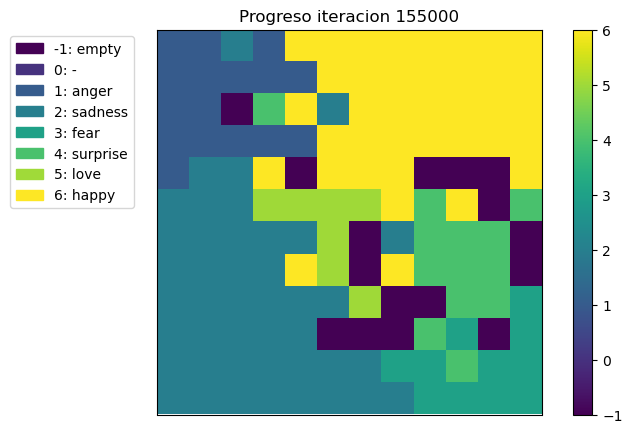

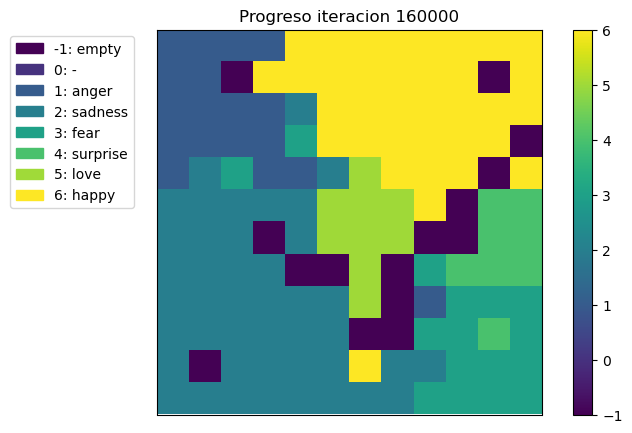

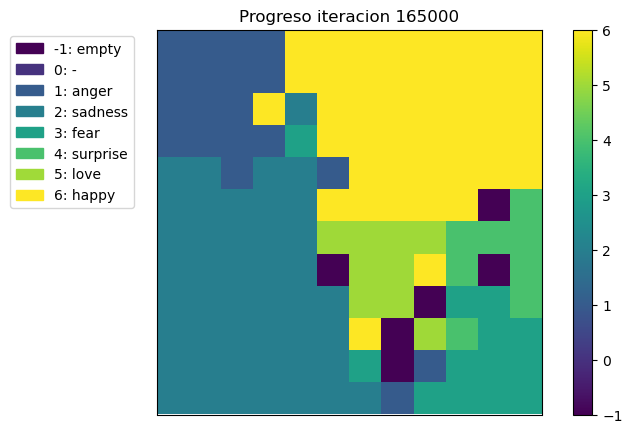

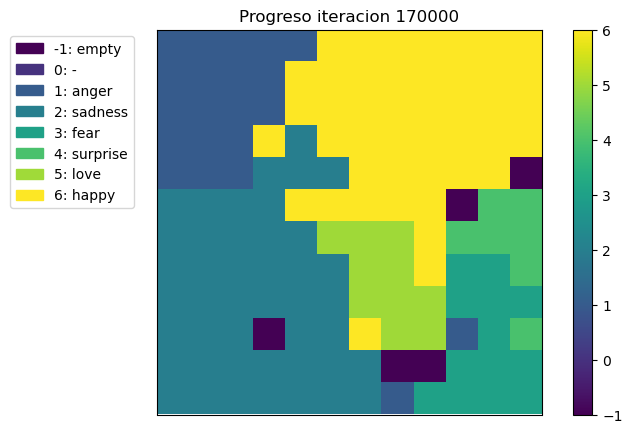

Epoch: [8/10]


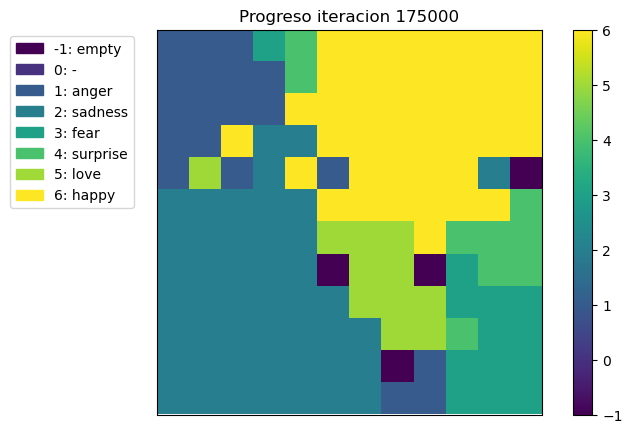

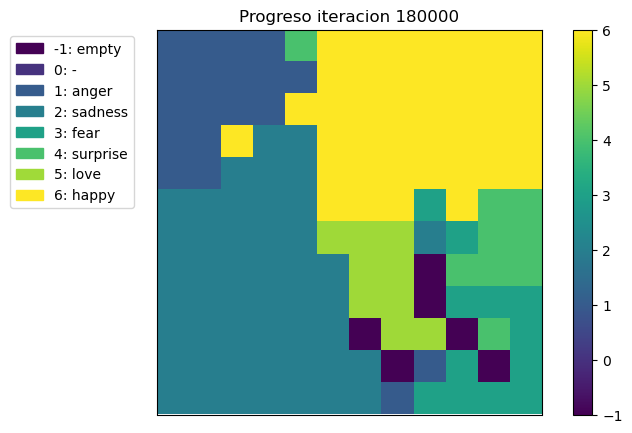

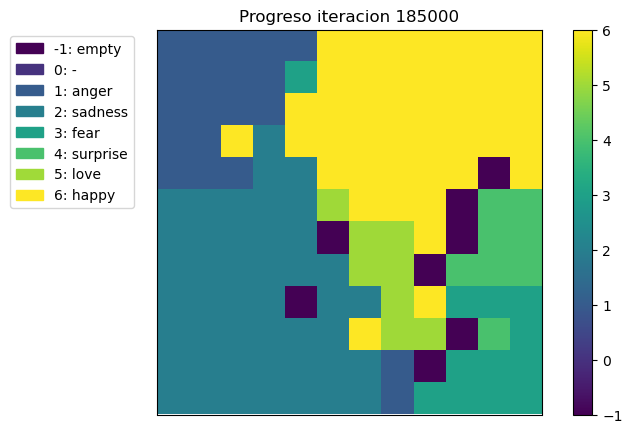

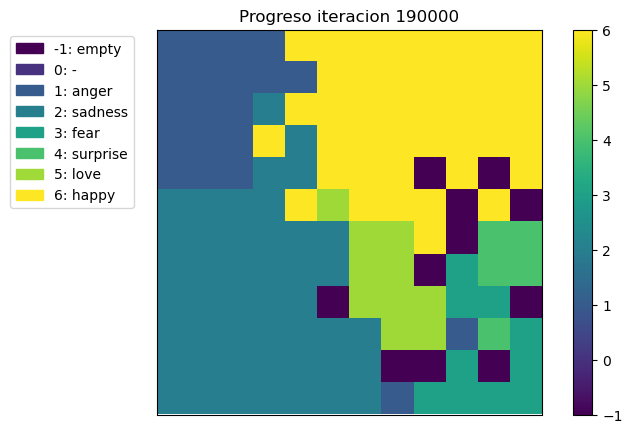

Epoch: [9/10]


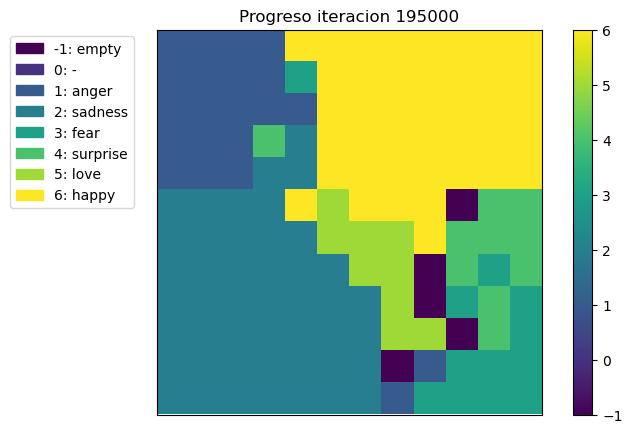

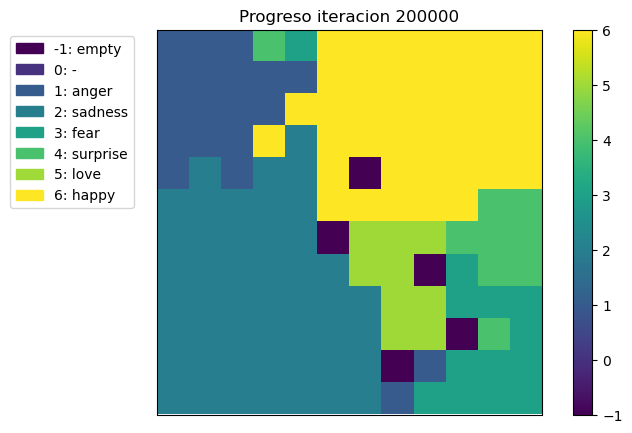

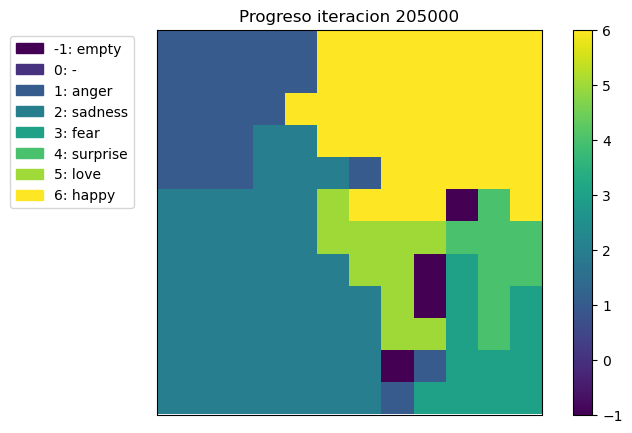

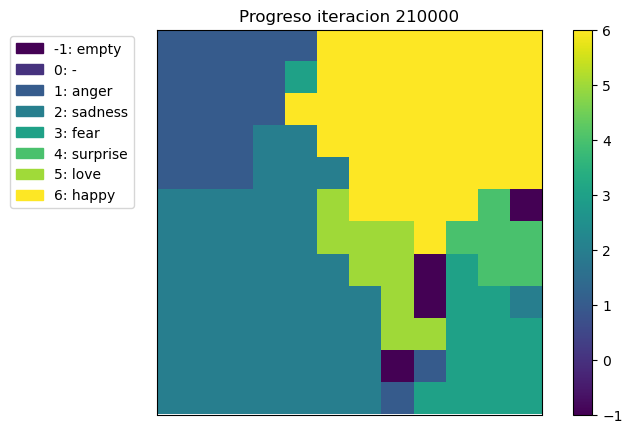

Epoch: [10/10]


In [24]:
# ir viendo en que paso de entrenamiento se esta
step = 0

# visualizar mapa cada ciertos pasos
steps_visualize = 5000

# iterar en las epocas
for epoca in range(NUM_EPOCHS):
    

  # hacer un shufle en los vectores para esta iteracion
  # es decir, permutar las filas
  X_norm_shufle = np.random.permutation(X_norm)

  # iterar en todos los datos
  for t in range(X_norm_shufle.shape[0]):
    
        
    # cada cierto numero de pasos, mostrar 
    # el progreso con el mapa
    if step % steps_visualize == 0:
      visualize(som, f"Progreso iteracion {step}", save_name = f'imagen_{step:06d}')

    # ver cual es el dato de este step
    input_data = X_norm_shufle[t]

    # obtener el learning rate y neighbourhood range
    # de este step
    learning_rate, neighbourhood_range = lr_and_nb_range(step, max_steps)

    # obtener la neurona mas cercana, la bmu
    # de este dato particular
    winner_neuron = bmu_neuron(input_data, som)

    # actualizar los pesos de la bmu y su vecindario
    # iterar en todas las neuronas
    for row in range(NUM_ROWS):
      for col in range(NUM_COLS):

        # ver si es parte del vecindario
        if manhattan_distance([row,col],winner_neuron) <= neighbourhood_range:

          # si si lo es, hacer la actualizacion de ese vector
          # usando el learning rate
          som[row][col] += learning_rate*(input_data - som[row][col])

    # marcar que se termina este paso
    step = step + 1

  # avisar progreso
  print(f"Epoch: [{epoca+1}/{NUM_EPOCHS}]")

Ver el mapa final aprendido

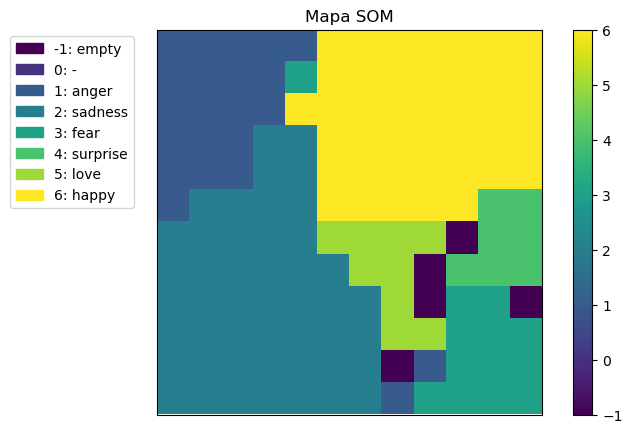

In [25]:
visualize(som)

Se puede apreciar que las emociones estan separadas entre si. Esto es precisamente el resultado que se buscaba encontrar. Ademas, se puede ver que las emociones afinen tienden colindar.

## Clasificación de sentimiento usando BERT y SOM

Si se quiere clasificar una oración, se realiza el siguiente procedimiento.

Primero que vectoriza la oración usando el BERT. Despues, se pasa ese vector por la SOM y se ve cual es la neurona mas cercana. Finalmente, se obsesrva la etiqueta de esa neurona, esta es la etiqueta asignada a la oración.

In [26]:
# obtener la etiqueta de cada neurona
etiquetas_som = etiquetar_som(X, emociones_codificadas, som)
etiquetas_som.shape

(12, 12)

Hacer una funcion que pueda clasificar las oraciones de acuerdo a la emocion.

In [27]:
def clasificar_oracion(oracion_input):
    # toma  una oracion
    # encuentra su bmu en la SOM
    # le asigna a la oracion la etiqueta de la bmu
    
    
    # obtener el vector de la oracion
    vector_input = vectorizar_oraciones([oracion_input])
    
    # obtener la bmu para este input data
    bmu_vector_input = bmu_neuron(vector_input, som)
    
    # obtener la etiqueta de la bmu
    etiqueta_vector_input = int(etiquetas_som[bmu_vector_input[0], bmu_vector_input[1]])
    
    # ver que emociones representa esta
    emocion_vector_input = dict_emociones_inv[etiqueta_vector_input]
    
    # hacer la grafica
    
    # graficarla

    # haver la figura
    fig, ax = plt.subplots(figsize=(8, 5))

    # quitar ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.imshow(etiquetas_som, vmin=min(list(dict_colores.keys())), vmax=max(list(dict_colores.keys())))
    plt.colorbar()

    plt.scatter(bmu_vector_input[1], bmu_vector_input[0], color = 'red', s=200)

    # titulo
    ax.set_title("Ver la oracion en el mapa de la SOM")

    # poner los handles, para la leyenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=plt.cm.viridis((i+1)/(len(dict_colores)-1)))
               for i in dict_colores.keys()]
    # delimitar los labels de la leyenda                
    labels = [f'{i}: {dict_colores[i]}' for i in dict_colores.keys()]

    # Mostrar la leyenda
    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.4, 1))

    plt.show()
    
    
    # imprimir
    
    print("Se quiere clasificar la siguiente oracion:")
    print(oracion_input)
    
    print(f"Se le asigna la emocion: {emocion_vector_input}")
    
    

Hacer unas pruebas

Vectorizando
Progreso: [1/1]


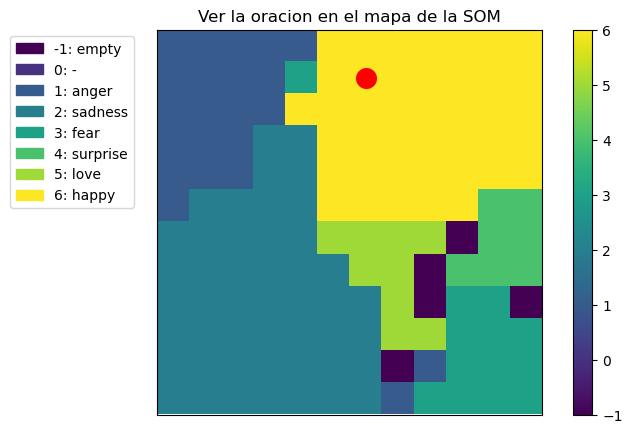

Se quiere clasificar la siguiente oracion:
I feel ecstatic every time I see the vibrant colors of a sunset
Se le asigna la emocion: happy


In [31]:
clasificar_oracion("I feel ecstatic every time I see the vibrant colors of a sunset")

Vectorizando
Progreso: [1/1]


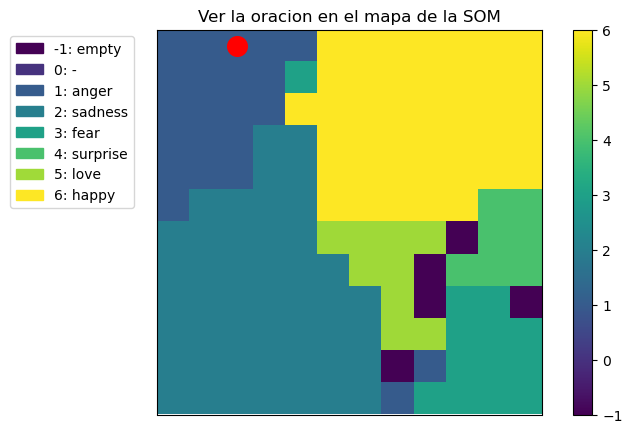

Se quiere clasificar la siguiente oracion:
Road rage is something I struggle with, especially during rush hour traffic
Se le asigna la emocion: anger


In [32]:
clasificar_oracion("Road rage is something I struggle with, especially during rush hour traffic")

Vectorizando
Progreso: [1/1]


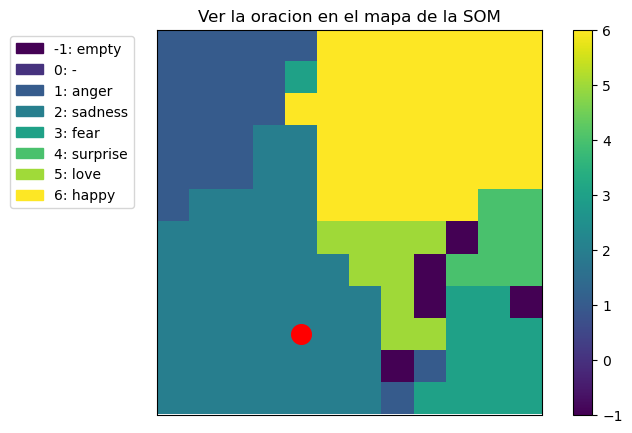

Se quiere clasificar la siguiente oracion:
The loneliness that comes with being far from family often brings a sense of sadness
Se le asigna la emocion: sadness


In [34]:
clasificar_oracion("The loneliness that comes with being far from family often brings a sense of sadness")

Vectorizando
Progreso: [1/1]


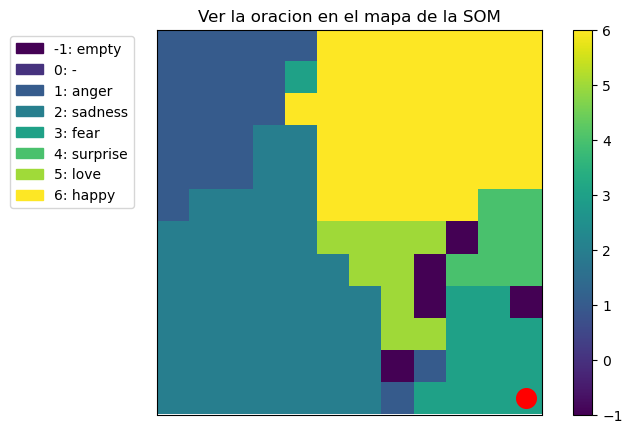

Se quiere clasificar la siguiente oracion:
The uncertainty of the future sometimes evokes feelings of fear and anxiety
Se le asigna la emocion: fear


In [35]:
clasificar_oracion("The uncertainty of the future sometimes evokes feelings of fear and anxiety")

Vectorizando
Progreso: [1/1]


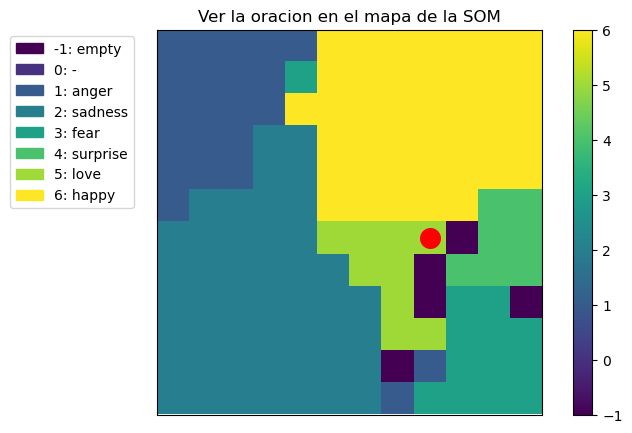

Se quiere clasificar la siguiente oracion:
Seeing my partner's smile after a long day instantly fills my heart with love
Se le asigna la emocion: love


In [36]:
clasificar_oracion("Seeing my partner's smile after a long day instantly fills my heart with love")

Vectorizando
Progreso: [1/1]


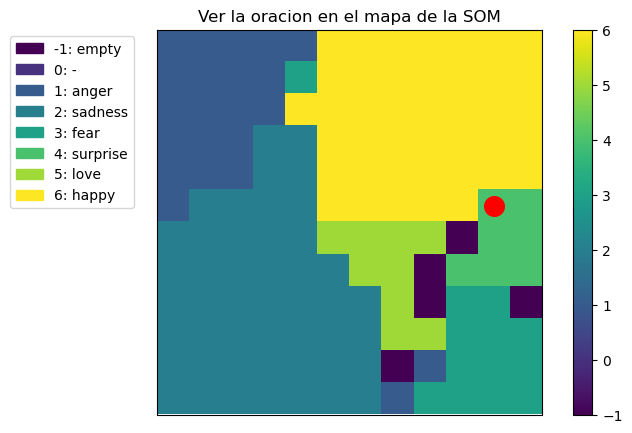

Se quiere clasificar la siguiente oracion:
Discovering a hidden talent in myself was a surprising and empowering revelation
Se le asigna la emocion: surprise


In [37]:
clasificar_oracion("Discovering a hidden talent in myself was a surprising and empowering revelation")